In [2]:
import pandas as pd

df = pd.read_csv("../data/raw/sales_train.csv")

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
total_cnt_day = df['item_cnt_day'].sum()
print(total_cnt_day)

3648206.0


In [5]:
block_cnt = df['item_cnt_day'].groupby(df['date_block_num']).sum()

In [22]:
total_cnt = block_cnt.sum()

In [6]:
sold = df[df['item_cnt_day'] >= 0]
return_goods = df[df['item_cnt_day'] < 0]

In [24]:
print(sold['item_cnt_day'].sum())
print(return_goods['item_cnt_day'].sum())

3655747.0
-7541.0


In [34]:
unique_date_per_block_num = df['date'].groupby(df['date_block_num']).nunique()
print(unique_date_per_block_num)

date_block_num
0     31
1     28
2     31
3     30
4     31
5     30
6     31
7     31
8     30
9     31
10    30
11    31
12    31
13    28
14    31
15    30
16    31
17    30
18    31
19    31
20    30
21    31
22    30
23    31
24    31
25    28
26    31
27    30
28    31
29    30
30    31
31    31
32    30
33    31
Name: date, dtype: int64


ta thấy block nào cũng đủ date trong tháng -> có thể tính tổng days = nunique cột date

In [54]:
total_days_of_selling = unique_date_per_block_num.sum()

print(total_days_of_selling)

1034


In [58]:
non_zero_demand_days = df['date'].groupby(sold['item_id']).nunique()

zero_demand_days = total_days_of_selling - non_zero_demand_days

zero_ratio = zero_demand_days / total_days_of_selling

print(non_zero_demand_days)
print(zero_demand_days)
print(zero_ratio)

item_id
0.0          1
1.0          6
2.0          2
3.0          2
4.0          1
          ... 
22165.0      2
22166.0    270
22167.0    570
22168.0      6
22169.0      1
Name: date, Length: 21804, dtype: int64
item_id
0.0        1033
1.0        1028
2.0        1032
3.0        1032
4.0        1033
           ... 
22165.0    1032
22166.0     764
22167.0     464
22168.0    1028
22169.0    1033
Name: date, Length: 21804, dtype: int64
item_id
0.0        0.999033
1.0        0.994197
2.0        0.998066
3.0        0.998066
4.0        0.999033
             ...   
22165.0    0.998066
22166.0    0.738878
22167.0    0.448743
22168.0    0.994197
22169.0    0.999033
Name: date, Length: 21804, dtype: float64


đếm tổng string khác nhau của 1 loại item => số ngày mà sản phẩm đó được bán

In [ ]:
print(non_zero_demand_days.describe())

count    21804.000000
mean        70.559989
std        109.182634
min          1.000000
25%          6.000000
50%         29.000000
75%         86.000000
max       1033.000000
Name: date, dtype: float64


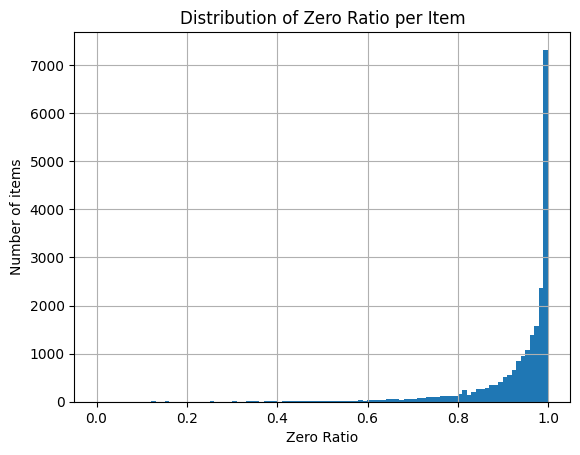

count    21804.000000
mean         0.931760
std          0.105592
min          0.000967
25%          0.916828
50%          0.971954
75%          0.994197
max          0.999033
Name: date, dtype: float64


In [62]:
zero_ratio.hist(bins=100)
plt.xlabel('Zero Ratio')
plt.ylabel('Number of items')
plt.title('Distribution of Zero Ratio per Item')
plt.show()
print(zero_ratio.describe())

In [86]:
day_sell_of_item = df['date'].groupby(sold['item_id']).unique()

In [103]:
items_df = pd.concat([zero_ratio, day_sell_of_item], axis=1)
items_df.columns = ['zero_ratio', 'days_sold']
print(items_df)

         zero_ratio                                          days_sold
item_id                                                               
0.0        0.999033                                       [01.09.2014]
1.0        0.994197  [04.04.2014, 02.04.2014, 06.07.2014, 04.08.201...
2.0        0.998066                           [24.08.2014, 12.11.2014]
3.0        0.998066                           [05.07.2014, 26.08.2014]
4.0        0.999033                                       [19.09.2014]
...             ...                                                ...
22165.0    0.998066                           [26.08.2013, 18.05.2014]
22166.0    0.738878  [31.10.2013, 30.10.2013, 27.10.2013, 26.10.201...
22167.0    0.448743  [29.09.2013, 28.09.2013, 30.09.2013, 27.09.201...
22168.0    0.994197  [20.01.2013, 15.01.2013, 02.02.2013, 17.02.201...
22169.0    0.999033                                       [21.03.2014]

[21804 rows x 2 columns]


In [ ]:
from src.utils.date_caculator import compute_interarrival



items_df['interarrival'] = items_df['days_sold'].map(compute_interarrival)

print(items_df["interarrival"].info())

<class 'pandas.core.series.Series'>
Index: 21804 entries, 0.0 to 22169.0
Series name: interarrival
Non-Null Count  Dtype 
--------------  ----- 
21804 non-null  object
dtypes: object(1)
memory usage: 340.7+ KB
None
